In [ ]:
!git clone https://github.com/KashyapKishore/AssameseTokenizer.git
%cd AssameseTokenizer

Cloning into 'AssameseTokenizer'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 28 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 16.28 KiB | 5.43 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/AssameseTokenizer


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from assamesetokenizer import tokenize_assamese, preprocess_text
import random

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Internship Project/15kdataset.csv',encoding= 'utf-8-sig').dropna()
df1.drop('Serial Number',axis=1,inplace= True)
df1.drop('English Translation',axis=1,inplace= True)

df1.rename(columns={'Assamese Text':'text','Sentiment':'sentiment'},inplace=True)

df1_shuffle = df1.sample(frac=1, random_state=42)
df1_shuffle.reset_index(drop=True, inplace=True)


df2 = pd.read_csv('/content/drive/MyDrive/Internship Project/Assamese_Sentiment_35k_Cleaned.csv',encoding= 'utf-8-sig').dropna()

df2_shuffle = df2.sample(frac=1,random_state=42)
df2_shuffle.reset_index(drop=True, inplace=True)


df3 = pd.read_csv('/content/drive/MyDrive/Internship Project/balanced_dataset.csv',encoding='utf-8-sig').dropna()

df3.rename(columns={'Assamese Text':'text','Sentiments':'sentiment'},inplace=True)

df3_shuffle = df3.sample(frac = 1,random_state = 42)
df3_shuffle.reset_index(drop=True,inplace=True)

df4 = pd.read_csv('/content/drive/MyDrive/Internship Project/BALANCED_Corpus1.csv',encoding='utf-8-sig').dropna()

df4_shuffle = df4.sample(frac=1,random_state=42)
df4_shuffle.reset_index(drop=True,inplace=True)

df4.drop('Serial No',axis=1,inplace=True)

df4.rename(columns = {'Assamese Sentence':'text','Sentiment':'sentiment'},inplace=True)



df5 = pd.read_csv('/content/drive/MyDrive/Internship Project/BALANCED_Corpus2.csv',encoding = 'utf-8-sig').dropna()

df5_shuffle = df5.sample(frac=1,random_state=42)
df5_shuffle.reset_index(drop=True,inplace=True)

df5.drop('Serial No',axis=1,inplace=True)

df5.rename(columns = {'Assamese Sentence':'text','Sentiment':'sentiment'},inplace=True)


df = pd.concat([df1_shuffle,df2_shuffle, df3_shuffle, df4_shuffle,df5_shuffle], ignore_index=True)

df['sentiment'] = df['sentiment'].str.lower()

df = df.dropna(subset=['sentiment']).reset_index(drop=True)

df['clean_text'] = df['text'].astype(str).apply(preprocess_text)

(np.int64(30275), np.int64(30354), np.int64(30172))

## For evaluating the train set we can do the following method

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_encoded'], test_size=0.2, stratify=df['label_encoded'], random_state=42
)

In [ ]:
all_tokens = []
for sentence in df['clean_text']:
    all_tokens.extend(tokenize_assamese(sentence))

vocab = ['<PAD>', '<UNK>'] + [w for w, _ in Counter(all_tokens).most_common(20000)]
word2idx = {word: idx for idx, word in enumerate(vocab)}
pad_idx = word2idx['<PAD>']

In [ ]:
def encode_sentence(sentence, maxlen=100):
    tokens = tokenize_assamese(sentence)
    ids = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    return ids[:maxlen] + [pad_idx] * (maxlen - len(ids))

In [ ]:
class AssameseDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [encode_sentence(t) for t in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

train_dataset = AssameseDataset(X_train.tolist(), y_train.tolist())
test_dataset = AssameseDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(self.dropout(h))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMModel(
    vocab_size=len(vocab),
    embed_dim=300,
    hidden_dim=128,
    num_classes=len(le.classes_),
    pad_idx=pad_idx
).to(device)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_model(epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

train_model(75)

NameError: name 'BiLSTMModel' is not defined

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = torch.argmax(out, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.tolist())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.79      0.76      6071
     neutral       0.63      0.58      0.60      6035
    positive       0.64      0.64      0.64      6055

    accuracy                           0.67     18161
   macro avg       0.67      0.67      0.67     18161
weighted avg       0.67      0.67      0.67     18161



## Full Training the dataset for any testset



In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sentiment'])

In [ ]:
all_tokens = []
for sentence in df['clean_text']:
    all_tokens.extend(tokenize_assamese(sentence))

vocab = ['<PAD>', '<UNK>'] + [w for w, _ in Counter(all_tokens).most_common(20000)]
word2idx = {word: idx for idx, word in enumerate(vocab)}
pad_idx = word2idx['<PAD>']

In [ ]:
def encode_sentence(sentence, maxlen=100):
    tokens = tokenize_assamese(sentence)
    ids = [word2idx.get(token, word2idx.get('<UNK>')) for token in tokens]
    return ids[:maxlen] + [pad_idx] * (maxlen - len(ids))

In [ ]:
class AssameseDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [encode_sentence(t) for t in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

full_dataset = AssameseDataset(df['clean_text'].tolist(), df['label_encoded'].tolist())
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTMModel, self).__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
      embedded = self.embedding(x)
      lstm_out, _ = self.lstm(embedded)
      attn_scores = self.attention(lstm_out).squeeze(-1)
      mask = (x != pad_idx)
      attn_scores[~mask] = float('-inf')
      attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)
      context = torch.sum(attn_weights * lstm_out, dim=1)
      output = self.fc(self.dropout(context))
      return output

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMModel(
    vocab_size=len(vocab),
    embed_dim=300,
    hidden_dim=128,
    num_classes=len(le.classes_),
    pad_idx=pad_idx
).to(device)

In [ ]:
weights = compute_class_weight('balanced', classes=np.unique(df['label_encoded']), y=df['label_encoded'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/50 - Loss: 0.9226
Epoch 2/50 - Loss: 0.8458
Epoch 3/50 - Loss: 0.7113
Epoch 4/50 - Loss: 0.5697
Epoch 5/50 - Loss: 0.4563
Epoch 6/50 - Loss: 0.3690
Epoch 7/50 - Loss: 0.3096
Epoch 8/50 - Loss: 0.2677
Epoch 9/50 - Loss: 0.2288
Epoch 10/50 - Loss: 0.2058
Epoch 11/50 - Loss: 0.1847
Epoch 12/50 - Loss: 0.1697
Epoch 13/50 - Loss: 0.1537
Epoch 14/50 - Loss: 0.1432
Epoch 15/50 - Loss: 0.1350
Epoch 16/50 - Loss: 0.1267
Epoch 17/50 - Loss: 0.1167
Epoch 18/50 - Loss: 0.1126
Epoch 19/50 - Loss: 0.1079
Epoch 20/50 - Loss: 0.1044
Epoch 21/50 - Loss: 0.0986
Epoch 22/50 - Loss: 0.0980
Epoch 23/50 - Loss: 0.0932
Epoch 24/50 - Loss: 0.0889
Epoch 25/50 - Loss: 0.0861
Epoch 26/50 - Loss: 0.0842
Epoch 27/50 - Loss: 0.0838
Epoch 28/50 - Loss: 0.0772
Epoch 29/50 - Loss: 0.0743
Epoch 30/50 - Loss: 0.0806
Epoch 31/50 - Loss: 0.0731
Epoch 32/50 - Loss: 0.0721
Epoch 33/50 - Loss: 0.0671
Epoch 34/50 - Loss: 0.0690
Epoch 35/50 - Loss: 0.0684
Epoch 36/50 - Loss: 0.0693
Epoch 37/50 - Loss: 0.0640
Epoch 38/5

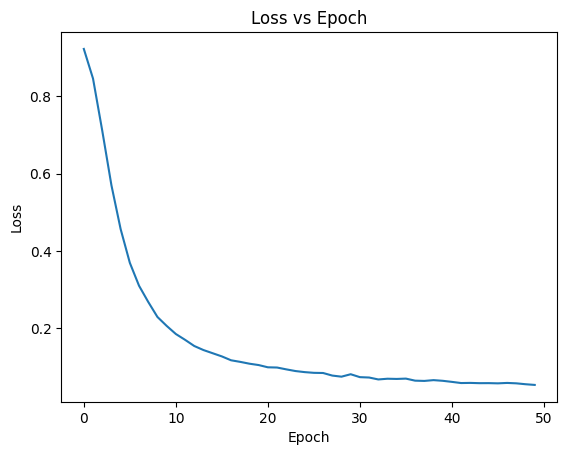

In [ ]:
import matplotlib.pyplot as plt
def train_model(epochs=10):
    model.train()
    loss_L = []
    for epoch in range(epochs):
        total_loss = 0
        for x, y in full_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(full_loader)
        loss_L.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        if epoch+1 == epochs:
            plt.plot(loss_L)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss vs Epoch')
            plt.show()

train_model(50)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Internship Project/sentiment-testset.csv',encoding='utf-8-sig').dropna()

test_df.dropna(subset=['text', 'sentiment'], inplace=True)

test_df['clean_text'] = test_df['text'].apply(preprocess_text)

test_df['sentiment'] = test_df['sentiment'].str.lower()

test_df['label_encoded'] = le.transform(test_df['sentiment'])

In [ ]:
class AssameseTestDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [encode_sentence(t) for t in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

In [ ]:
print("Classes:", le.classes_)
print("num_classes:", len(le.classes_))
print("pad_idx:", pad_idx)
print("vocab size:", len(vocab))

Classes: ['negative' 'neutral' 'positive']
num_classes: 3
pad_idx: 0
vocab size: 20002


In [ ]:
test_dataset = AssameseTestDataset(test_df['clean_text'].tolist(), test_df['label_encoded'].tolist())
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import classification_report, f1_score


criterion = nn.CrossEntropyLoss(weight=class_weights)

model.eval()
all_preds = []
all_labels = []
total_loss = 0
total_batches = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item()
        total_batches += 1

        preds = torch.argmax(out, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().tolist())

avg_test_loss = total_loss / total_batches
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"\n Test Loss: {avg_test_loss:.4f}")
print(f" Macro F1 Score: {f1:.4f}")
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


100%|██████████| 4/4 [00:00<00:00, 68.82it/s]


🧪 Test Loss: 4.5461
📈 Macro F1 Score: 0.4245

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.37      0.46        35
     neutral       0.43      0.59      0.50        34
    positive       0.31      0.32      0.32        31

    accuracy                           0.43       100
   macro avg       0.45      0.43      0.42       100
weighted avg       0.45      0.43      0.43       100



In [ ]:
import os

folders = [
    "sentiment-analyzer/model",
    "sentiment-analyzer/data",
    "sentiment-analyzer/src"
]

files = [
    "sentiment-analyzer/README.md",
    "sentiment-analyzer/requirements.txt",
    "sentiment-analyzer/LICENSE",
    "sentiment-analyzer/.gitignore",
    "sentiment-analyzer/notebook.ipynb",
    "sentiment-analyzer/src/model.py",
    "sentiment-analyzer/src/utils.py"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

for file in files:
    with open(file, 'w') as f:
        f.write("# placeholder" if file.endswith(".py") else "")

In [ ]:
import os

base_path = "/content/drive/MyDrive/sentiment-analyzer"

folders = [
    "model", "data", "src"
]

for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

print("Project structure created.")

Project structure created.


In [ ]:
!mv "/content/drive/MyDrive/Internship Project/Sentiment-analyizer-assamese-text.ipynb" "/content/drive/MyDrive/sentiment-analyzer/notebook.ipynb"


In [17]:
with open(f"{base_path}/src/model.py", "w") as f:
    f.write("""
import torch.nn as nn
import torch


class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTMModel, self).__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
      embedded = self.embedding(x)
      lstm_out, _ = self.lstm(embedded)
      attn_scores = self.attention(lstm_out).squeeze(-1)
      mask = (x != pad_idx)
      attn_scores[~mask] = float('-inf')
      attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)
      context = torch.sum(attn_weights * lstm_out, dim=1)
      output = self.fc(self.dropout(context))
      return output


""")

In [18]:
with open(f"{base_path}/README.md", "w") as f:
    f.write("""
# Sentiment Analyzer using BiLSTM + Attention

This is a simple sentiment analysis model trained on a custom dataset using PyTorch.

## Contents
- `notebook.ipynb`: Main training notebook
- `src/model.py`: BiLSTM model definition
- `model/`: Trained model (.pt file)
- `data/`: Sample input or processed data

## Usage
Run `notebook.ipynb` in Google Colab.

## Team
- Subham Das
- Pritvi Raj
- Arpita Baruah
- Bhupali Das
""")

In [19]:
with open(f"{base_path}/requirements.txt", "w") as f:
    f.write("torch\npandas\nscikit-learn\nnumpy\ntqdm\nmatplotlib.pyplot\nrandom\n")

In [20]:
with open(f"{base_path}/.gitignore", "w") as f:
    f.write("__pycache__/\n*.pt\n*.ipynb_checkpoints\n")

In [21]:
with open(f"{base_path}/LICENSE", "w") as f:
    f.write("MIT License\n\nCopyright (c) 2025 Subham")